In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Setting parameters (these values can be changed)
nrows = 800
ncols = 800
xcenter = -0.4601222
ycenter = .570286
bound   = .002
x_domain, y_domain = np.linspace(xcenter-bound, xcenter+bound, ncols), np.linspace(ycenter-bound, ycenter+bound, nrows)
max_iterations = 2000  # any positive integer value
colormap = "nipy_spectral"  # set to any matplotlib valid colormap


def mandelbrot(x, y):
    z = 0
    p = 2
    c = complex(x, y)
    for iteration_number in range(max_iterations):
        if abs(z) >= 2:
            return iteration_number
        z = z**p + c
    return 0

def plot_data(iteration_array):
    # Plotting the data
    ax = plt.axes()
    ax.set_aspect("equal")
    graph = ax.pcolormesh(x_domain, y_domain, iteration_array, cmap=colormap,
                          norm=matplotlib.colors.LogNorm())
    plt.colorbar(graph)
    plt.xlabel("Real-Axis")
    plt.ylabel("Imaginary-Axis")
    plt.show()

In [3]:
%%time
iteration_array = np.zeros((nrows, ncols))
for (i, x) in enumerate(x_domain):
    for (j, y) in enumerate(y_domain):
        iteration_array[j, i] = mandelbrot(x, y)

CPU times: user 11.9 s, sys: 1.99 ms, total: 11.9 s
Wall time: 11.9 s


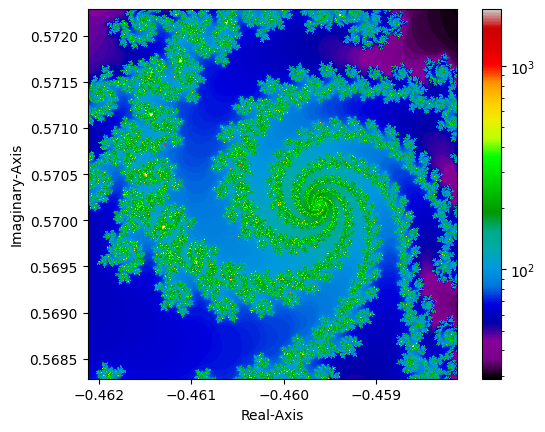

In [4]:
plot_data(iteration_array)

In [5]:
import sys

print(sys._is_gil_enabled())

False


In [6]:
import os

ncpus = os.cpu_count()

# Adjust this to fit your host. Not easy to detect it manually.
# Set to 1 if hyperthreading is disabled.
hyperthreads_per_core = 2

# Number of rows to dispatch to each task
chunk_size = 4

num_workers_domain = [1] + list(range(2, ncpus + 1, 2))

In [7]:
def process_worker(j_y, x_domain, mandelbrot):
    ret = np.empty((len(j_y), x_domain.shape[0]))
    for (i, x) in enumerate(x_domain):
        for (j, y) in j_y:
            ret[j-j_y[0][0], i] = mandelbrot(x, y)
    return ret

In [8]:
import itertools
from joblib import Parallel, delayed

def run_process_pool(num_workers):
    chunks = itertools.batched(enumerate(y_domain), chunk_size, strict=True)
    return Parallel(n_jobs=num_workers)(
        delayed(process_worker)(arg, x_domain, mandelbrot) for arg in chunks
    )

times_processes = {}

for i in num_workers_domain:
    iteration_array = np.zeros((nrows, ncols))
    print(f"{i} workers:")
    %timeit -n 1 -r 3 -v runtime np.vstack(run_process_pool(i))
    times_processes[i] = runtime

1 workers:
11.7 s ± 91.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 workers:
6.45 s ± 155 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 workers:
3.5 s ± 72 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 workers:
2.38 s ± 152 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8 workers:
1.79 s ± 132 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
10 workers:
1.51 s ± 120 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
12 workers:
1.28 s ± 117 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14 workers:
1.14 s ± 27.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
16 workers:
982 ms ± 36.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
18 workers:
1.07 s ± 154 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
20 workers:
989 ms ± 34.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
22 workers:
861 ms ± 17.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
24 workers:
871 ms ± 33.1 ms per loop (mean ± std. dev

In [9]:
def thread_worker(j_y):
    ret = np.empty((len(j_y), x_domain.shape[0]))
    for (i, x) in enumerate(x_domain):
        for (j, y) in j_y:
            iteration_array[j, i] = mandelbrot(x, y)

In [10]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

import itertools

def run_thread_pool(num_workers):
    with ThreadPoolExecutor(max_workers=num_workers) as tpe:
        chunks = itertools.batched(enumerate(y_domain), chunk_size, strict=True)
        try:
            futures = [tpe.submit(thread_worker, arg) for arg in chunks]
            # block until all work finishes
            concurrent.futures.wait(futures)
        finally:
            # check for exceptions in worker threads
            [f.result() for f in futures]

times_threads = {}

for i in num_workers_domain:
    iteration_array = np.zeros((nrows, ncols))
    print(f"{i} workers:")
    %timeit -n 1 -r 3 -v runtime run_thread_pool(i)
    times_threads[i] = runtime

1 workers:
11.5 s ± 86.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 workers:
5.97 s ± 37.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 workers:
3.05 s ± 7.72 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 workers:
2.06 s ± 11.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8 workers:
1.55 s ± 10.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
10 workers:
1.27 s ± 4.05 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
12 workers:
1.04 s ± 3.74 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
14 workers:
919 ms ± 3.36 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
16 workers:
805 ms ± 3.62 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
18 workers:
846 ms ± 23.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
20 workers:
866 ms ± 2.77 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
22 workers:
869 ms ± 22 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
24 workers:
887 ms ± 14.8 ms per loop (mean ± s

In [11]:
def get_results(times):
    all_runtimes = np.array(list(time.all_runs for time in times.values()))
    runtimes = np.mean(all_runtimes, axis=1)
    err = np.std(all_runtimes, axis=1)
    nworkers = np.array(list(times))
    return {'runtimes': runtimes, 'err': err, 'nworkers': nworkers}

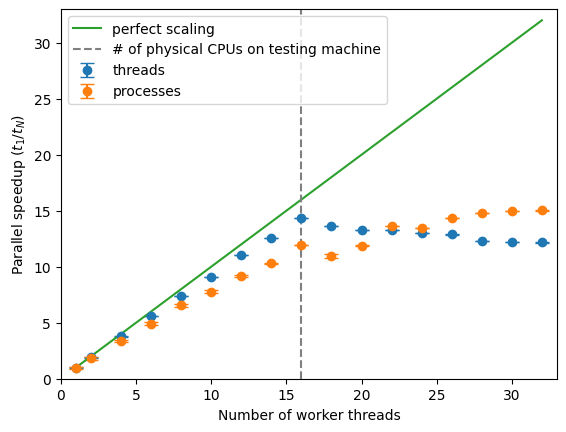

In [12]:
threads = get_results(times_threads)
processes = get_results(times_processes)

plt.errorbar(threads['nworkers'], threads['runtimes'][0]/threads['runtimes'], yerr=threads['err'], fmt='o', capsize=5, label='threads')
plt.errorbar(processes['nworkers'], processes['runtimes'][0]/processes['runtimes'], yerr=processes['err'], fmt='o', capsize=5, label='processes')
plt.plot(threads['nworkers'], threads['nworkers'], label="perfect scaling")
plt.plot(
    [ncpus // hyperthreads_per_core, ncpus // hyperthreads_per_core],
    [0, ncpus + 1],
    linestyle="--",
    color="grey",
    label="# of physical CPUs on testing machine",
)
plt.legend()
plt.xlim(0, ncpus + 1)
plt.ylim(0, ncpus + 1)
plt.xlabel("Number of worker threads")
plt.ylabel("Parallel speedup ($t_1/t_N$)")
plt.show()